# Solving the lunar lander environment using Reinforcement learning 


The purpose of this work is to develop a reinforcement learning model capable of solving the problem presented by the "Moon Lander" environment in the Gymnasium library. The objective is to train a model that can make decisions to successfully land the spaceship on the moon's surface with a smooth landing. Finally the evaluation of the working and performance wil be presented. 

## Environment analysis

The enviroment used in this work is a optimization problem for the landind trajectory of a spaceship. The objective is to control the spaceship's landing by dealing with the controls and landing it in a specifical area of the moon. The goal is to achieve a smooth landing while minimizing fuel consumption.

![Lunar Lander](https://gymnasium.farama.org/_images/lunar_lander.gif "Episodio del lunar lander sin entrenar")





### Observation

The observation consists of 6 continuous and discrete values, which refer to the following aspects of the environment state:
* Spaceship's x position
* Spaceship's y position
* Velocity in the x direction
* Velocity in the y direction
* Spaceship's angle
* Angular velocity
* Flag 1: 1 if the left leg of the spaceship is in contact with the moon's surface, 0 otherwise
* Flag 2: 1 if the right leg of the spaceship is in contact with the moon's surface, 0 otherwise.



### Actions

There are 4 possible discrete actions (0 or 1) to be taken in each frame of the game:

   * Do nothing
   * Activate left orientation thruster
   * Activate main bottom thruster
   * Activate right orientation thruster

The possible actions are selected through a list of 4 elements: [NOTHING, LEFT, MAIN, RIGHT].
Rewards

The environment provides a reward after each frame, depending on the actions taken. This reward can be positive or negative and is granted based on the following factors:

   * It increases/decreases as the spaceship approaches/moves away from the landing platform.
   * It increases/decreases as the spaceship moves slower/faster.
   * It decreases as the spaceship becomes more tilted (non-horizontal angle).
   * It increases by 10 points for each leg in contact with the ground.
   * It decreases by 0.03 points for each frame in which the lateral thruster is activated.
   * It decreases by 0.3 points for each frame in which the main thruster is activated.
   * A final score of -100 points is received if the spaceship crashes or +100 points if the spaceship lands safely.

After each frame, a reward is received based on the action taken. To obtain the reward for each episode, simply sum up the rewards obtained from all the frames that compose the episode.
Expected Average Final Reward

It will be considered successful completion of an episode if the sum of scores for all episodes results in +200 or above. This threshold is indicated in the environment documentation. However, the algorithm is set to stop training once this score is surpassed by calculating the average of the last trained episodes. The number of episodes used for averaging is determined by the parameter NUMBER_OF_REWARDS_TO_AVERAGE, which in this case is set to 20.

## Proposed Solution

To solve the problem at hand, we will use the Deep Q-learning (DQL) technique, which combines the Q-learning algorithm with deep neural networks. In essence, this method employs a neural network to approximate the Q-function, which evaluates the quality of actions in a given state. DQL has been chosen due to its ability to handle all possible states of the spaceship in an environment with 8 variables. This approach enables us to leverage the complexity of the observations and make optimal decisions at each moment.

While the actor-critic technique could also have been utilized, DQL has been selected since the episodes in this environment are relatively short, and the problem is not as complex in comparison. This decision has been made with considerations for simplicity in the training process.

##  Implementación


#### Preparatory Steps

The main required libraries are imported, and the GPU device is set up to accelerate the training process.

In [11]:
import numpy as np
import gymnasium as gym
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [12]:
if torch.cuda.is_available():
    print("¡Sí, hay una GPU disponible!")
else:
    print("Lo siento, no se detectó una GPU.")

¡Sí, hay una GPU disponible!


In [13]:
device=torch.device("cuda")

#### Importing the Environment

We import the Lunar Lander environment and set the render_mode to enable video visualization later on.

In [14]:
ENV_NAME="LunarLander-v2"
env=gym.make(ENV_NAME,render_mode="rgb_array")

### Experience Buffer

The following code section corresponds to the experience buffer, which plays a crucial role in training the model. Its main objective is to store a wide range of actions and the corresponding rewards, and then randomly sample these experiences. This prevents experiences from being returned with high correlation, which could negatively impact the training process by introducing biases due to such correlation.

In [15]:
from collections import namedtuple, deque  # Import the collections library to create deque data structures with a fixed size.
import random

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))  # Initialize a deque structure with 4 possible variables.

class ReplayMemory(object):  # Create the class that belongs to the experience buffer.

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)  # Initialize the structure.

    def push(self, state, action, next_state, reward):  # Method to store a new experience in the structure.
        self.memory.append(Transition(state, action, next_state, reward))
        """Save a transition"""

    def sample(self, batch_size):  # Method to return random samples from the deque structure, the number of returned samples depends on the batch size.
        return random.sample(self.memory, batch_size)

    def __len__(self):  # Method that returns the state of the memory.
        return len(self.memory)

### Neural Network Model

In this class, a Deep Q-Network (DQN) model is implemented using PyTorch. The neural network takes the environment observations as input, and the number of outputs corresponds to the number of possible actions that the agent can take.

With this model, the algorithm will be able to approximate the Q-value for each action in the current state. During training, the model takes the current environment observation as input and produces a prediction of the Q-function for each possible action as output.

Once the training is completed, this model will be used to choose the best action given a specific state.

In [22]:
from torchsummary import summary # Importo la libreria torchsummary

n_actions = env.action_space.n  # Get the number of actions in the environment
state, info = env.reset()  # Get the initial state
n_observations = len(state)  # Get the number of observations

class DQN(nn.Module):  # Create the class for the model

  def __init__(self,n_observations,n_actions):
    super(DQN,self).__init__()
    self.layer1 = nn.Linear(n_observations,128)
    self.layer2 = nn.Linear(128,128)
    self.layer3 = nn.Linear(128,n_actions)
  
  def forward(self,x):
    x=F.relu(self.layer1(x))  
    x=F.relu(self.layer2(x)) 
    return self.layer3(x) 


model_summary = DQN(n_observations, n_actions).to(device)  # Create the model
summary(model_summary, (n_observations,))  # Print the model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,152
            Linear-2                  [-1, 128]          16,512
            Linear-3                    [-1, 4]             516
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


### Hyperparameters

In the following section, the hyperparameters have been defined, which allow us to configure and adjust important variables of the training process to improve its performance and accuracy. Some of these parameters have been determined through trial and error.

In [17]:
BATCH_SIZE = 256 # Number of experiences used to feed the neural network
GAMMA = 0.99 # Discount factor
LR = 1e-4 # Learning rate of the neural network

EPS_START = 0.99 # Initial value of epsilon
EPS_END = 0.02 # Final value of epsilon
EPS_DECAY = 0.999985 # Epsilon decay rate per frame

## Agent

The following class belongs to the agent, which is responsible for deciding which action to take based on a given state.

### Agent's Policy

This agent uses an e-greedy policy to choose an action at each step. This means it uses the epsilon probability to select a random action or use the trained neural network to obtain the Q-values of the possible actions and choose the best one using torch.max.

Once we obtain the action, we apply it to the environment and receive the reward, the next state, or determine if the episode has ended.

In [25]:
class Agent:
    def __init__(self, env):# Initialize the environment within the class
        self.env = env
               
    def step(self, net, state, epsilon=0.0, device="cpu"):       
         if np.random.random() > epsilon: # Exploration/Exploitation trade-off                            
            with torch.no_grad():
                return net(state).max(1)[1].view(1,1)  # Exploitation. Return the action from the model that yields the best Q-value
         else:    
                return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)  # Exploration. Return a random action to explore the environment.

### Model Optimization

The optimize_model function is responsible for using the Bellman equation to calculate the expected values of the actions. It uses the SmoothL1Loss loss function to optimize the neural network through gradient descent. Finally, the Adam optimization algorithm is used to update the weights of the neural network.

In [26]:
def optimize_model():
    # Take a number of samples from the experience memory
    transition = buffer.sample(BATCH_SIZE)  
    
    # Unpack the selected transitions from the previous line
    batch = Transition(*zip(*transition))   
    
    # Get non-final states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]) 
            
    # Create batches of states, actions, and rewards
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
        
    # Calculate Q-values of the actions taken in the current states
    state_action_values = main_net(state_batch).gather(1, action_batch)
    
    # Create a tensor of zeros of size BATCH_SIZE for the Q-values of the actions in the next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # If the transition is not final, calculate the Q-values of the actions in the next states
    with torch.no_grad(): 
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
          
    # Calculate the expected values using the Bellman equation
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch 

    # Compute the loss function using the Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # Apply gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_value_(main_net.parameters(), 100)
    optimizer.step()

### Main Training Loop

The following block will execute the main program that calls the previously created functions and classes in order to train the agent.
Process Details

Firstly, the main neural network model and the target are initialized. This allows the target model to not be updated immediately at each step and to be smoothly updated with the weights of the main model. Then, we will initialize the classes corresponding to the agent and the experience buffer, necessary for sampling experiences and selecting the best action following a specific policy.

Once all the variables are declared, we enter a loop from which we cannot exit until the training is completed. This loop is divided into two phases: sampling and learning.

In the sampling phase, the first thing we do is calculate a new value of epsilon, which will decrease at each iteration of the loop. This epsilon value is sent to the agent along with the current state. The agent will use an epsilon-greedy policy to return an action to perform, which will be stored in the experience buffer. Once the experience buffer reaches a certain number of stored experiences (in this case, 20000), the loop will also execute the learning phase, which is performed within the optimize method.

In the learning phase, the first thing we do is obtain a batch of experiences from the experience memory (Experience Replay), and for each of them, we calculate the Q-function values using the model and the expected values using the main neural network model. Then, we calculate the expected values using the Bellman equation, in order to compare these last two values and calculate the model's loss.

Finally, we use the necessary PyTorch functions to perform backpropagation through the model and allow it to learn.

In [85]:
# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observation
state, info = env.reset()

# Number of features in the state
n_observations = len(state)

main_net = DQN(n_observations, n_actions).to(device)  # Initialize the main model
target_net = DQN(n_observations, n_actions).to(device)  # Initialize the target network Q

target_net.load_state_dict(main_net.state_dict())

# Optimizer - AdamW used to optimize the weights
optimizer = optim.AdamW(main_net.parameters(), lr=LR, amsgrad=True)

buffer = ReplayMemory(20000)  # Initialize the experience memory

agent = Agent(env)

epsilon = EPS_START

reward_hist = []
epsilon_hist = []
mean_hist = []
last_mean = 0
steps = 0
episode = 0

while True:  # Episode loop

    state, info = env.reset()  # Reset the environment
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    acum_rewards = 0  # Clear the reward accumulator

    while True:  # Frame loop

        steps += 1  # Add one step or frame to the total number of steps
        epsilon = max(epsilon * EPS_DECAY, EPS_END)  # Calculate the epsilon for this episode

        action = agent.step(main_net, state, epsilon, device)  # Call the agent to take an action based on the current state and epsilon

        observation, reward, terminated, truncated, _ = env.step(action.item())  # Execute the action on the environment and get the new state, reward, and check if the episode has finished
        acum_rewards += reward  # Accumulate the rewards per episode
        reward = torch.tensor([reward], device=device)  # Convert the obtained reward to a PyTorch tensor

        done = terminated or truncated  # Flag for episode termination

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)  # If the episode has not finished, observe the new state and convert it to a tensor

        buffer.push(state, action, next_state, reward)  # Store the transition in the experience replay memory D
        state = next_state  # Move to the next state

        if len(buffer) > BATCH_SIZE:  # We don't optimize until the experience memory has a minimum number of experiences
            optimize_model()  # Call the function to optimize the model

        # Synchronize the parameters of the main model with those of the target network every certain number of frames
        if steps % 1000 == 0:
            target_net.load_state_dict(main_net.state_dict())

        # If the episode ends
        if done:
            reward_hist.append(acum_rewards)  # Save the accumulated rewards in a list
            epsilon_hist.append(epsilon)  # Save the last epsilon
            episode += 1  # Add one episode to the number of episodes
            break

    if episode >= 20:
        mean_hist.append(np.mean(reward_hist[-20:]))
        last_mean = mean_hist[-1:][0]

    if episode % 20 == 0:
        print(f"Episode: {episode} | Rewards: {last_mean:.5f} | Epsilon: {epsilon}")

    if last_mean == 200:
        print("Fin")
        torch.save(main_net.state_dict(), ENV_NAME + ".dat")
        break


Episode: 20 | Rewards: -197.55978 | Epsilon: 0.9611588783662466
Episode: 40 | Rewards: -170.84962 | Epsilon: 0.9360318678178736
Episode: 60 | Rewards: -167.38584 | Epsilon: 0.9095675871393598
Episode: 80 | Rewards: -149.14206 | Epsilon: 0.8835599018047532
Episode: 100 | Rewards: -116.27503 | Epsilon: 0.8588625327076785
Episode: 120 | Rewards: -99.83909 | Epsilon: 0.8317805442545325
Episode: 140 | Rewards: -89.99193 | Epsilon: 0.8061931893159411
Episode: 160 | Rewards: -93.58524 | Epsilon: 0.782941658716149
Episode: 180 | Rewards: -87.92672 | Epsilon: 0.7594260530014066
Episode: 200 | Rewards: -80.74224 | Epsilon: 0.7362521993041657
Episode: 220 | Rewards: -78.95445 | Epsilon: 0.7105486766577617
Episode: 240 | Rewards: -56.50153 | Epsilon: 0.6889799871922866
Episode: 260 | Rewards: -75.15187 | Epsilon: 0.6675451225976685
Episode: 280 | Rewards: -76.70486 | Epsilon: 0.6454203013627754
Episode: 300 | Rewards: -62.73131 | Epsilon: 0.6213294454867928
Episode: 320 | Rewards: -52.40161 | Epsi

KeyboardInterrupt: 

### Training Model Results

Once the average of the rewards from the last 20 episodes exceeded 250 points, it is considered that the training has finished. This score is the threshold set to conclude the training. We observe a positive progression in the rewards throughout the process, as they evolved from initial negative values to significantly higher scores. This evolution is a clear indication that the agent has learned to take the correct actions in order to maximize its final score.

It is important to note that the training of the agent was not linear. Initially, the rewards were low and negative, reflecting the initial learning period where the agent explored the environment and tried different actions. As the training progressed, the rewards started to improve progressively, indicating that the agent was acquiring knowledge and optimizing its behavior.

# Graphs of Results

The following code will allow us to visualize the graphs that demonstrate the agent's evolution. One of them shows the average of the rewards from the current episode and the previous 19 episodes.

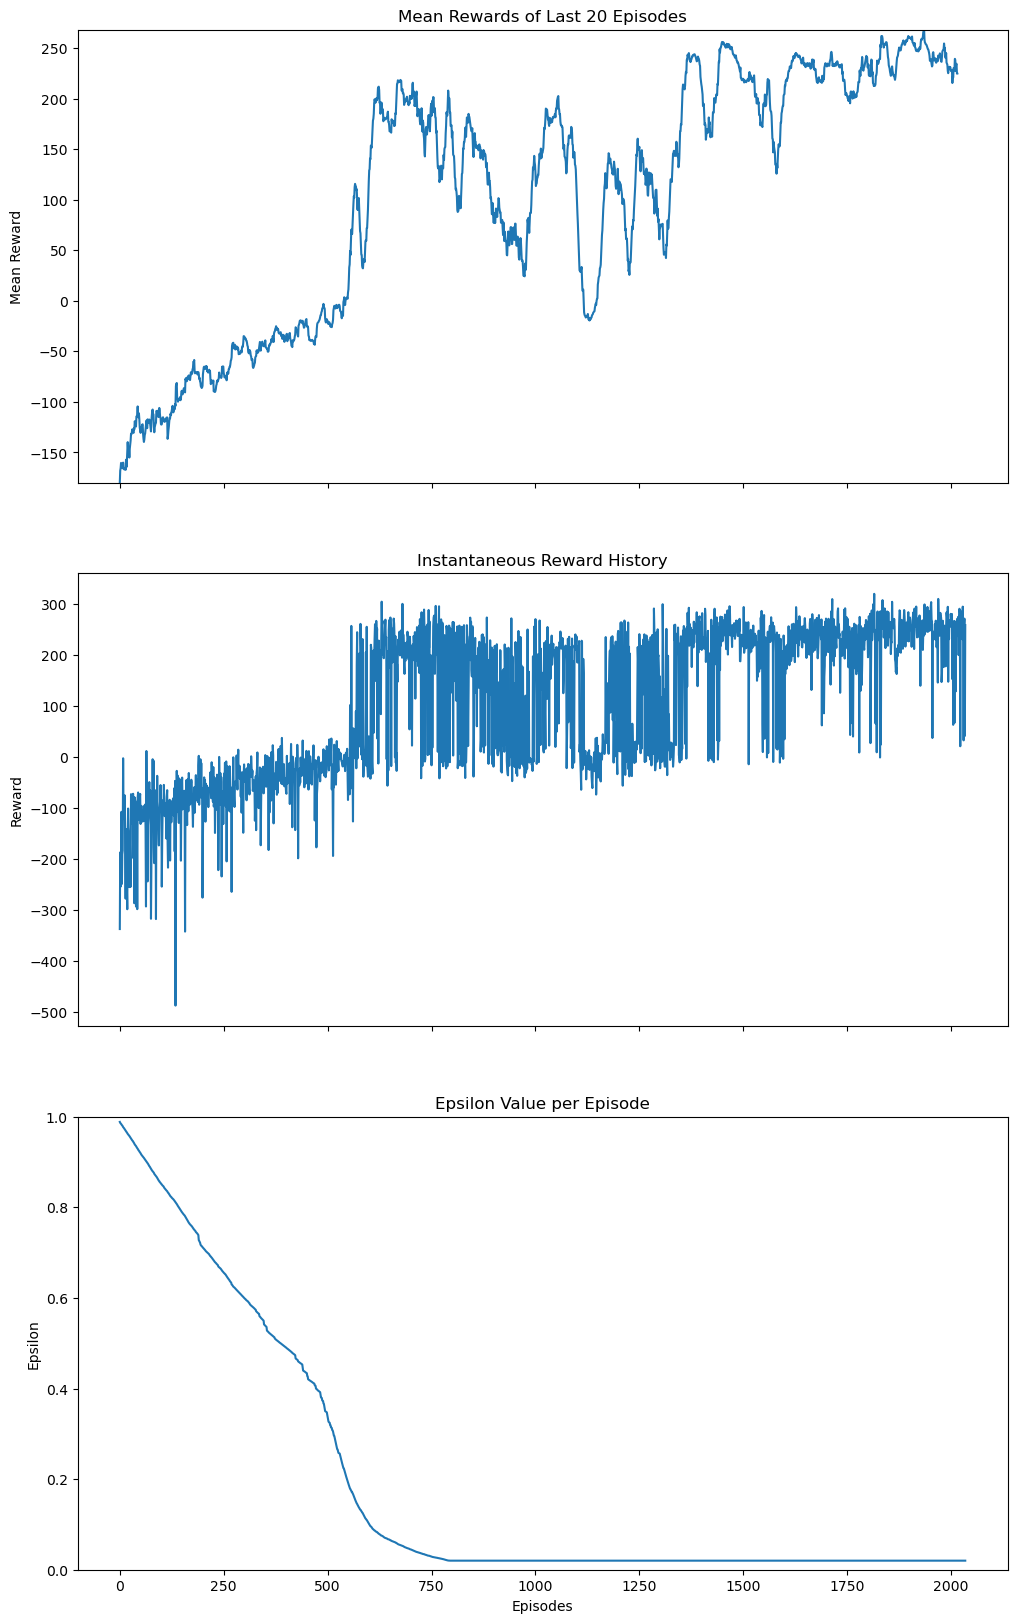

In [80]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(12, 20))

# Plot the first graph with mean_hist values
ax1.plot(mean_hist)
ax1.set_ylabel('Mean Reward')
ax1.set_title('Mean Rewards of Last 20 Episodes')

# Plot the epsilon_hist values in the second graph
ax3.plot(epsilon_hist)
ax3.set_xlabel('Episodes')
ax3.set_title('Epsilon Value per Episode')
ax3.set_ylabel('Epsilon')

# Plot the reward_hist values in the third graph
ax2.plot(reward_hist)
ax2.set_title('Instantaneous Reward History')
ax2.set_ylabel('Reward')

# Adjust the Y-axis limits
ax1.set_ylim([min(mean_hist), max(mean_hist)])
ax3.set_ylim([0, 1.0])

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.2)

# Show the resulting figure
plt.show()

The graphs clearly show how the model improves the rewards obtained per episode as it learns the best actions to take in each state. The learning process ends when an average reward of 250 or higher is achieved. In the last graph, we can observe how the value of "epsilon" decreases as the training progresses. This implies a reduction in the exploration of random actions and an increase in the exploitation of actions that have shown to generate the best rewards.


#### Visualization of an Episode with Trained Model

As a final step, the Lunar Lander environment has been imported again, and the weights of the previously trained model have been loaded. A game was played, and the entire episode was recorded as a video using the RecordVideo wrapper, which captures and stores the complete sequence. At the end, it can be observed how the algorithm is able to guide the spacecraft for a successful landing on the moon. The resulting video showcases the application of the learned actions during training and demonstrates the model's successful performance in solving the Lunar Lander challenge.

A pre-generated video is available in the Video folder within the delivered working directory.

In [84]:
import torch
import gymnasium as gym


#Get number of actions from gym action space
n_actions = env.action_space.n

#Get the number of state observaation
state,info = env.reset()

#number of features in the state
n_observations = len(state)

weights = torch.load("LunarLander-v2" + ".dat")

model= DQN(n_observations,n_actions).to(device) 

model.load_state_dict(weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

env_test = gym.make('LunarLander-v2',                  
                    render_mode= "rgb_array"
                   )
env_test  = gym.wrappers.RecordVideo(env_test , 'video')
reward=0

observation ,_  = env_test.reset()

while True:
    env.render()

    # Convierte la observación a un tensor y realiza una inferencia con el modelo
    observation_tensor = torch.tensor(observation, dtype=torch.float32).to(device)
    action_probs = model(observation_tensor)
    
    # Elige la acción con mayor probabilidad
    action = torch.argmax(action_probs).item()

    # Realiza la acción y recibe la siguiente observación, la recompensa y si el juego ha terminado
    observation, reward, done, info,_ = env_test.step(action)
    reward+=reward
    if reward==200:
        break
    
env_test.close()

Moviepy - Building video E:\Users\ramal\Documents\MI3\Trabajos\Lunar-Lander_RL\video\rl-video-episode-0.mp4.
Moviepy - Writing video E:\Users\ramal\Documents\MI3\Trabajos\Lunar-Lander_RL\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready E:\Users\ramal\Documents\MI3\Trabajos\Lunar-Lander_RL\video\rl-video-episode-0.mp4


In [ ]:
print(reward)

In [61]:
from IPython.display import HTML

HTML("""
<video width="320" height="240" controls>
  <source src="video/rl-video-episode-0.mp4" type="video/mp4">
</video>
""")

## Conclusions
### Analysis of Results

As we have observed, the training results have been satisfactory, as the agent has learned to make the correct control decisions to perform a quick and safe landing of the spacecraft. Once trained, the agent is able to achieve a reward of 200 in each episode, which is sufficient to consider the game successfully completed according to the environment's documentation.
### Other Tested Environments

In addition to this environment, an attempt was made to train a model for the ATARI game "Skiing," but the expected results were not obtained. A similar approach to this work was used, but with a convolutional neural network model to take game frames as observations. However, the training process took a long time due to the duration of an episode, which ended when the skier crossed the finish line. For this reason, a simpler environment was chosen that could be trained with my GPU in a reasonable time.
### Lessons Learned

Throughout the development of this project, valuable knowledge has been acquired in various key areas. Firstly, skills in designing neural network architectures have been developed, enabling the creation of an effective model to address a specific reinforcement learning problem. Additionally, experience has been gained in working with simulation environments provided by the Gym library.

One notable advantage of Gym's environments is their accessibility, allowing anyone interested in learning about reinforcement learning to quickly start developing models tailored to the specific needs of each environment. This ease of use has enabled the application of acquired theoretical knowledge and exploration of different approaches and techniques in a controlled environment.

Furthermore, through this project, a deeper understanding of theoretical and practical concepts related to reinforcement learning has been achieved. First-hand experience has been gained in applying these concepts to real-world problems and the importance of experimentation to achieve optimal results.

### Next Steps

Upon completing this project, it would be a good step to attempt training a model for a more complex environment than the one used in this work. A natural progression would be to devote more efforts to modeling an agent capable of dealing with an ATARI environment. It would also be beneficial to explore other types of reinforcement learning techniques to further expand knowledge in this fascinating field.


## References

    * Torres, J. (2021). Introducción al aprendizaje por refuerzo profundo. Teoría y práctica en Python. Amazon.
    * PyTorch Official Website. Retrieved from: https://pytorch.org/docs/stable/index.html
    * Introduction to Various Reinforcement Learning Algorithms. Part I (Q-Learning, SARSA, DQN, DDPG). Retrieved from: https://medium.com/towards-data-science/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287